In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df_sup=pd.read_csv('./Countries_usefulFeatures.csv')

In [4]:
df_train.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0


In [5]:
df_train.tail()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
969635,969636,NaN,NaN,Zimbabwe,14240168,0.607106,2020-06-08,Fatalities,0
969636,969637,NaN,NaN,Zimbabwe,14240168,0.060711,2020-06-09,ConfirmedCases,27
969637,969638,NaN,NaN,Zimbabwe,14240168,0.607106,2020-06-09,Fatalities,0
969638,969639,NaN,NaN,Zimbabwe,14240168,0.060711,2020-06-10,ConfirmedCases,6
969639,969640,NaN,NaN,Zimbabwe,14240168,0.607106,2020-06-10,Fatalities,0


In [6]:
df_train.shape

(969640, 9)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969640 entries, 0 to 969639
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              969640 non-null  int64  
 1   County          880040 non-null  object 
 2   Province_State  917280 non-null  object 
 3   Country_Region  969640 non-null  object 
 4   Population      969640 non-null  int64  
 5   Weight          969640 non-null  float64
 6   Date            969640 non-null  object 
 7   Target          969640 non-null  object 
 8   TargetValue     969640 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 66.6+ MB


In [8]:
df_train.describe(include='all')

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
count,969640.000000,880040,917280,969640,9.696400e+05,969640.000000,969640,969640,969640.000000
unique,NaN,1840,133,187,NaN,NaN,140,2,NaN
top,NaN,Washington,Texas,US,NaN,NaN,2020-04-08,Fatalities,NaN
freq,NaN,8680,71400,895440,NaN,NaN,6926,484820,NaN
mean,484820.500000,NaN,NaN,NaN,2.720127e+06,0.530870,NaN,NaN,12.563518
std,279911.101847,NaN,NaN,NaN,3.477771e+07,0.451909,NaN,NaN,302.524795
min,1.000000,NaN,NaN,NaN,8.600000e+01,0.047491,NaN,NaN,-10034.000000
25%,242410.750000,NaN,NaN,NaN,1.213300e+04,0.096838,NaN,NaN,0.000000
50%,484820.500000,NaN,NaN,NaN,3.053100e+04,0.349413,NaN,NaN,0.000000
75%,727230.250000,NaN,NaN,NaN,1.056120e+05,0.968379,NaN,NaN,0.000000


Text(0.5, 1.0, 'Proportion of Features')

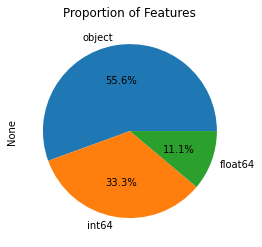

In [9]:
feature_types = df_train.dtypes.value_counts()
feature_types.plot.pie(autopct='%1.1f%%')
plt.title('Proportion of Features')

In [10]:
missing_data = df_train.isnull().sum()

missing_data

Id                    0
County            89600
Province_State    52360
Country_Region        0
Population            0
Weight                0
Date                  0
Target                0
TargetValue           0
dtype: int64

In [11]:
missing_proportion = df_train.isnull().sum() / df_train.shape[0] * 100

missing_proportion

Id                0.000000
County            9.240543
Province_State    5.399942
Country_Region    0.000000
Population        0.000000
Weight            0.000000
Date              0.000000
Target            0.000000
TargetValue       0.000000
dtype: float64

In [12]:
#check miss data
missing_dict = {'missing data': missing_data, 'missing proportion * 100%': missing_proportion}
df_missing = pd.DataFrame(missing_dict)
df_missing = pd.DataFrame(data=df_missing.values.T, columns=df_missing.index, index=df_missing.columns)
df_missing

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
missing data,0.0,89600.000000,52360.000000,0.0,0.0,0.0,0.0,0.0,0.0
missing proportion * 100%,0.0,9.240543,5.399942,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# deal with missing data(null values),if the province is null ,using country to fill it,if county is null, using province to fill it
# country->province->county
df_train['Province_State'][df_train['Province_State'].isnull()] = \
    df_train['Country_Region'][df_train['Province_State'].isnull()]
df_train['County'][df_train['County'].isnull()] = \
    df_train['Province_State'][df_train['County'].isnull()]
df_train

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0
1,2,Afghanistan,Afghanistan,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0
2,3,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0
3,4,Afghanistan,Afghanistan,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0
4,5,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0
...,...,...,...,...,...,...,...,...,...
969635,969636,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.607106,2020-06-08,Fatalities,0
969636,969637,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.060711,2020-06-09,ConfirmedCases,27
969637,969638,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.607106,2020-06-09,Fatalities,0
969638,969639,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.060711,2020-06-10,ConfirmedCases,6


In [14]:
# check missing data again
missing_data_2 = df_train.isnull().sum()

missing_data_2

Id                0
County            0
Province_State    0
Country_Region    0
Population        0
Weight            0
Date              0
Target            0
TargetValue       0
dtype: int64

In [15]:
#diff days means the days of Date  to the last day(6-10)
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train['Diff_Days'] = df_train['Date'].apply(lambda x: x - df_train.loc[0,'Date'])

df_train

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue,Diff_Days
0,1,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0,0 days
1,2,Afghanistan,Afghanistan,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0,0 days
2,3,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0,1 days
3,4,Afghanistan,Afghanistan,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0,1 days
4,5,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0,2 days
...,...,...,...,...,...,...,...,...,...,...
969635,969636,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.607106,2020-06-08,Fatalities,0,137 days
969636,969637,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.060711,2020-06-09,ConfirmedCases,27,138 days
969637,969638,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.607106,2020-06-09,Fatalities,0,138 days
969638,969639,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.060711,2020-06-10,ConfirmedCases,6,139 days


In [16]:
df_train['Diff_Days'] = df_train['Diff_Days'].apply(lambda x: int(str(x).replace(' days 00:00:00', '')))

df_train

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue,Diff_Days
0,1,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0,0
1,2,Afghanistan,Afghanistan,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0,0
2,3,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0,1
3,4,Afghanistan,Afghanistan,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0,1
4,5,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0,2
...,...,...,...,...,...,...,...,...,...,...
969635,969636,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.607106,2020-06-08,Fatalities,0,137
969636,969637,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.060711,2020-06-09,ConfirmedCases,27,138
969637,969638,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.607106,2020-06-09,Fatalities,0,138
969638,969639,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.060711,2020-06-10,ConfirmedCases,6,139


In [17]:
# remove the - in date
df_train['Date'] = df_train['Date'].apply(lambda x: int(str(x).rstrip(' 00:00:00').replace('-', '')))

df_train

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue,Diff_Days
0,1,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,20200123,ConfirmedCases,0,0
1,2,Afghanistan,Afghanistan,Afghanistan,27657145,0.583587,20200123,Fatalities,0,0
2,3,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,20200124,ConfirmedCases,0,1
3,4,Afghanistan,Afghanistan,Afghanistan,27657145,0.583587,20200124,Fatalities,0,1
4,5,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,20200125,ConfirmedCases,0,2
...,...,...,...,...,...,...,...,...,...,...
969635,969636,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.607106,20200608,Fatalities,0,137
969636,969637,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.060711,20200609,ConfirmedCases,27,138
969637,969638,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.607106,20200609,Fatalities,0,138
969638,969639,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.060711,2020061,ConfirmedCases,6,139


In [18]:
# add Avg_Population_by_County feature
# 
count_county_dict = df_train['County'].value_counts().to_dict()
df_train['Count_County'] = df_train['County'].apply(lambda x: count_county_dict[x])
df_train['Avg_Population_by_County'] = df_train.apply(lambda x: x['Population'] / x['Count_County'], axis=1)
# df_train = df_train.drop(labels='Count_County', axis=1)  # 删除County的数量这一列，讨论下要不要保留

In [19]:
#merge the supplment dataset
df_train=df_train.merge(df_sup[['Country_Region','Tourism','Latitude','Longtitude','Mean_Age','Lockdown_Date','Lockdown_Type']], on='Country_Region', how='inner', sort=False)
df_train

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue,Diff_Days,Count_County,Avg_Population_by_County,Tourism,Latitude,Longtitude,Mean_Age,Lockdown_Date,Lockdown_Type
0,1,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,20200123,ConfirmedCases,0,0,280,98775.517857,14000,33.939110,67.709953,17.3,2020-03-24,Full
1,2,Afghanistan,Afghanistan,Afghanistan,27657145,0.583587,20200123,Fatalities,0,0,280,98775.517857,14000,33.939110,67.709953,17.3,2020-03-24,Full
2,3,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,20200124,ConfirmedCases,0,1,280,98775.517857,14000,33.939110,67.709953,17.3,2020-03-24,Full
3,4,Afghanistan,Afghanistan,Afghanistan,27657145,0.583587,20200124,Fatalities,0,1,280,98775.517857,14000,33.939110,67.709953,17.3,2020-03-24,Full
4,5,Afghanistan,Afghanistan,Afghanistan,27657145,0.058359,20200125,ConfirmedCases,0,2,280,98775.517857,14000,33.939110,67.709953,17.3,2020-03-24,Full
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968795,969636,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.607106,20200608,Fatalities,0,137,280,50857.742857,2580000,-19.015438,29.154857,19.0,2020-03-30,Full
968796,969637,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.060711,20200609,ConfirmedCases,27,138,280,50857.742857,2580000,-19.015438,29.154857,19.0,2020-03-30,Full
968797,969638,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.607106,20200609,Fatalities,0,138,280,50857.742857,2580000,-19.015438,29.154857,19.0,2020-03-30,Full
968798,969639,Zimbabwe,Zimbabwe,Zimbabwe,14240168,0.060711,2020061,ConfirmedCases,6,139,280,50857.742857,2580000,-19.015438,29.154857,19.0,2020-03-30,Full


In [20]:
# using labelcoder to give County，Province_State，Country_Region，Target labels
le = LabelEncoder()
encoder= le.fit(df_train["Country_Region"])
df_train["Country_Region"] = encoder.transform(df_train["Country_Region"])
encoder= le.fit(df_train["Province_State"])
df_train["Province_State"] = encoder.transform(df_train["Province_State"])
encoder= le.fit(df_train["County"])
df_train["County"] = encoder.transform(df_train["County"])
encoder= le.fit(df_train["Target"])
df_train["Target"] = encoder.transform(df_train["Target"])

In [21]:
##give lockdown type labels
df_train=df_train.replace(np.nan,"None") 
encoder= le.fit(df_train["Lockdown_Type"])
df_train["Lockdown_Type"] = encoder.transform(df_train["Lockdown_Type"])   #2 is partial 0 is full 1 is none

In [22]:
#Calculates the duration of the lockdown
df_train=df_train.replace("None","2020-06-10")
df_train['Lockdown_Date'] = pd.to_datetime(df_train['Lockdown_Date'])
df_train['Lockdown_Days'] = df_train['Lockdown_Date'].apply(lambda x: pd.to_datetime("2020-06-10")-x)
df_train['Lockdown_Days'] = df_train['Lockdown_Days'].apply(lambda x: int(str(x).replace(' days 00:00:00', '')))

In [23]:
# change the Lockdown_Date type
df_train['Lockdown_Date'] = df_train['Lockdown_Date'].apply(lambda x: int(str(x).rstrip(' 00:00:00').replace('-', '')))

df_train

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue,Diff_Days,Count_County,Avg_Population_by_County,Tourism,Latitude,Longtitude,Mean_Age,Lockdown_Date,Lockdown_Type,Lockdown_Days
0,1,7,0,0,27657145,0.058359,20200123,0,0,0,280,98775.517857,14000,33.939110,67.709953,17.3,20200324,0,78
1,2,7,0,0,27657145,0.583587,20200123,1,0,0,280,98775.517857,14000,33.939110,67.709953,17.3,20200324,0,78
2,3,7,0,0,27657145,0.058359,20200124,0,0,1,280,98775.517857,14000,33.939110,67.709953,17.3,20200324,0,78
3,4,7,0,0,27657145,0.583587,20200124,1,0,1,280,98775.517857,14000,33.939110,67.709953,17.3,20200324,0,78
4,5,7,0,0,27657145,0.058359,20200125,0,0,2,280,98775.517857,14000,33.939110,67.709953,17.3,20200324,0,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968795,969636,2132,315,183,14240168,0.607106,20200608,1,0,137,280,50857.742857,2580000,-19.015438,29.154857,19.0,2020033,0,72
968796,969637,2132,315,183,14240168,0.060711,20200609,0,27,138,280,50857.742857,2580000,-19.015438,29.154857,19.0,2020033,0,72
968797,969638,2132,315,183,14240168,0.607106,20200609,1,0,138,280,50857.742857,2580000,-19.015438,29.154857,19.0,2020033,0,72
968798,969639,2132,315,183,14240168,0.060711,2020061,0,6,139,280,50857.742857,2580000,-19.015438,29.154857,19.0,2020033,0,72


In [24]:
#separate the whole dataset to 2 sub-dataset(confirmcase and fatalities)
df_train_confirmcase=df_train[df_train['Target']==0].reset_index(drop=True)
df_train_fatalities=df_train[df_train['Target']==1].reset_index(drop=True)

In [25]:
corr = df_train.corr()  #get the corr
corr

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue,Diff_Days,Count_County,Avg_Population_by_County,Tourism,Latitude,Longtitude,Mean_Age,Lockdown_Date,Lockdown_Type,Lockdown_Days
Id,1.000000,6.385992e-02,8.778437e-01,4.032823e-01,-9.843924e-02,4.539975e-02,-1.363116e-05,0.000002,-0.015136,2.889654e-04,8.391023e-03,-9.857378e-02,3.493733e-01,1.759915e-01,-3.389157e-01,1.899488e-01,1.517187e-01,3.101069e-01,-9.492435e-03
County,0.063860,1.000000e+00,1.072147e-01,8.756039e-02,-1.022597e-02,-4.563730e-03,-5.971114e-20,0.000000,0.012081,-1.136304e-18,4.154202e-02,-1.072769e-02,1.303530e-02,-7.811117e-03,1.333493e-02,4.293510e-03,1.242995e-03,9.236573e-03,2.149944e-02
Province_State,0.877844,1.072147e-01,1.000000e+00,1.699923e-01,-3.553606e-02,1.453431e-02,1.051500e-18,0.000000,0.000846,-4.197473e-18,-3.772509e-02,-3.583171e-02,9.466861e-02,2.643479e-02,-6.335317e-02,4.611195e-02,3.739531e-02,8.837611e-02,2.138508e-02
Country_Region,0.403282,8.756039e-02,1.699923e-01,1.000000e+00,-2.268383e-01,8.760464e-02,1.355195e-17,0.000000,-0.047599,1.757296e-19,1.365734e-01,-2.266820e-01,7.310409e-01,3.559494e-01,-7.539893e-01,3.433629e-01,2.911219e-01,6.945397e-01,-1.036013e-01
Population,-0.098439,-1.022597e-02,-3.553606e-02,-2.268383e-01,1.000000e+00,-3.977366e-02,-2.214048e-20,0.000000,0.161250,-6.043994e-19,-4.217617e-02,9.999029e-01,-1.748772e-01,-9.661342e-02,2.863129e-01,-1.460038e-01,-5.609489e-02,-2.435508e-01,1.183404e-01
Weight,0.045400,-4.563730e-03,1.453431e-02,8.760464e-02,-3.977366e-02,1.000000e+00,-2.952538e-20,0.961239,-0.040704,2.141064e-19,1.033305e-02,-3.926040e-02,9.131865e-02,4.552176e-02,-9.371619e-02,5.799395e-02,4.116030e-02,8.564533e-02,-7.235149e-03
Date,-0.000014,-5.971114e-20,1.051500e-18,1.355195e-17,-2.214048e-20,-2.952538e-20,1.000000e+00,0.000000,-0.001534,-4.717230e-02,1.903432e-18,2.725495e-19,3.782985e-19,-2.193820e-18,1.481884e-19,-4.100974e-19,2.348680e-19,6.231111e-19,1.298449e-18
Target,0.000002,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.612393e-01,0.000000e+00,1.000000,-0.037073,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
TargetValue,-0.015136,1.208141e-02,8.455494e-04,-4.759929e-02,1.612495e-01,-4.070427e-02,-1.533834e-03,-0.037073,1.000000,3.035471e-02,-1.916943e-02,1.604682e-01,-5.104946e-02,-2.026383e-02,4.735541e-02,-1.679747e-02,-1.291021e-02,-5.630522e-02,8.042905e-03
Diff_Days,0.000289,-1.136304e-18,-4.197473e-18,1.757296e-19,-6.043994e-19,2.141064e-19,-4.717230e-02,0.000000,0.030355,1.000000e+00,3.030369e-18,-2.691941e-19,-5.569327e-19,-3.479234e-19,2.939539e-19,5.719079e-19,-1.754672e-20,1.862077e-18,1.715211e-19


<AxesSubplot:>

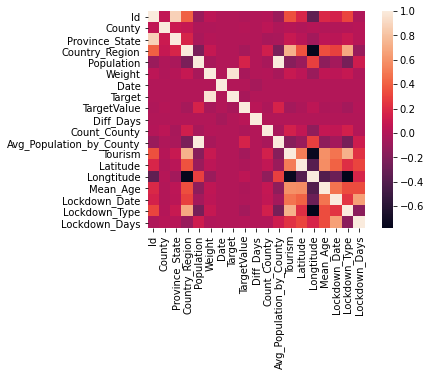

In [26]:
sns.heatmap(corr, square=True)  #draw the heatmap

In [27]:
#drop some useless feature through the corr
df_train_confirmcase=df_train_confirmcase.drop(["Id",'Population',"Target"],axis=1)
df_train_fatalities=df_train_fatalities.drop(["Id",'Population',"Target"],axis=1)

In [28]:
#new corr
new_corr = df_train_confirmcase.corr()
new_corr

,County,Province_State,Country_Region,Weight,Date,TargetValue,Diff_Days,Count_County,Avg_Population_by_County,Tourism,Latitude,Longtitude,Mean_Age,Lockdown_Date,Lockdown_Type,Lockdown_Days
County,1.000000e+00,1.072147e-01,8.756039e-02,-2.138660e-02,-4.926169e-19,0.016142,3.526631e-18,4.154202e-02,-1.072769e-02,1.303530e-02,-7.811117e-03,1.333493e-02,4.293510e-03,1.242995e-03,9.236573e-03,2.149944e-02
Province_State,1.072147e-01,1.000000e+00,1.699923e-01,6.811084e-02,-4.185863e-18,0.001061,-1.619041e-18,-3.772509e-02,-3.583171e-02,9.466861e-02,2.643479e-02,-6.335317e-02,4.611195e-02,3.739531e-02,8.837611e-02,2.138508e-02
Country_Region,8.756039e-02,1.699923e-01,1.000000e+00,4.105338e-01,-2.207463e-18,-0.063981,2.191452e-19,1.365734e-01,-2.266820e-01,7.310409e-01,3.559494e-01,-7.539893e-01,3.433629e-01,2.911219e-01,6.945397e-01,-1.036013e-01
Weight,-2.138660e-02,6.811084e-02,4.105338e-01,1.000000e+00,-1.038897e-20,-0.117748,-3.221015e-19,4.842283e-02,-1.839825e-01,4.279384e-01,2.133245e-01,-4.391738e-01,2.717718e-01,1.928858e-01,4.013521e-01,-3.390543e-02
Date,-4.926169e-19,-4.185863e-18,-2.207463e-18,-1.038897e-20,1.000000e+00,-0.002133,-4.717230e-02,1.489263e-18,-5.228030e-20,1.863676e-18,6.523727e-19,-3.324019e-18,-2.560831e-18,-6.928605e-19,-4.407451e-18,-3.586108e-18
TargetValue,1.614231e-02,1.060624e-03,-6.398062e-02,-1.177476e-01,-2.132566e-03,1.000000,4.095223e-02,-2.572580e-02,2.169596e-01,-6.955092e-02,-2.839934e-02,6.420914e-02,-2.418136e-02,-1.767149e-02,-7.559635e-02,1.058477e-02
Diff_Days,3.526631e-18,-1.619041e-18,2.191452e-19,-3.221015e-19,-4.717230e-02,0.040952,1.000000e+00,-4.333628e-18,2.416237e-19,-3.300034e-18,3.076678e-19,1.234352e-19,1.997139e-19,1.111292e-19,-2.453523e-18,-7.613435e-20
Count_County,4.154202e-02,-3.772509e-02,1.365734e-01,4.842283e-02,1.489263e-18,-0.025726,-4.333628e-18,1.000000e+00,-4.293458e-02,1.471361e-01,6.496587e-02,-1.397338e-01,7.550916e-02,6.585500e-02,1.399323e-01,2.901309e-04
Avg_Population_by_County,-1.072769e-02,-3.583171e-02,-2.266820e-01,-1.839825e-01,-5.228030e-20,0.216960,2.416237e-19,-4.293458e-02,1.000000e+00,-1.747223e-01,-9.679640e-02,2.863692e-01,-1.462917e-01,-5.630337e-02,-2.437373e-01,1.182754e-01
Tourism,1.303530e-02,9.466861e-02,7.310409e-01,4.279384e-01,1.863676e-18,-0.069551,-3.300034e-18,1.471361e-01,-1.747223e-01,1.000000e+00,5.131468e-01,-7.378167e-01,5.950309e-01,4.791982e-01,7.328682e-01,2.320925e-01


<AxesSubplot:>

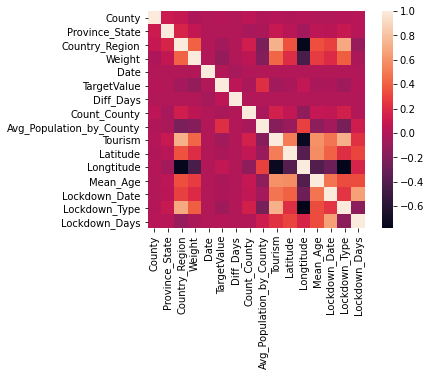

In [29]:
#new heat map 
sns.heatmap(new_corr, square=True)

In [30]:
#get the data and label
df_train_confirmcase_x=df_train_confirmcase.drop(['TargetValue'],axis=1)
df_train_confirmcase_y=df_train_confirmcase['TargetValue']
df_train_fatalities_x=df_train_fatalities.drop(['TargetValue',"Latitude","Longtitude"],axis=1)
df_train_fatalities_y=df_train_fatalities['TargetValue']

In [31]:
#using the train_test_split to separate the dataset (80%for train 20%for test)
train_x_confirmcase, test_x_confirmcase, train_y_confirmcase, test_y_confirmcase = train_test_split(df_train_confirmcase_x, df_train_confirmcase_y, test_size=0.8, random_state=1)
train_x_fatalities, test_x_fatalities, train_y_fatalities, test_y_fatalities = train_test_split(df_train_confirmcase_x, df_train_confirmcase_y, test_size=0.8, random_state=1)

In [32]:
#linear regression for confirmcase
lr_model = LinearRegression()
lr_model.fit(train_x_confirmcase, train_y_confirmcase)
lr_predict = lr_model.predict(test_x_confirmcase)
lr_r2_score = r2_score(test_y_confirmcase, lr_predict)
MAE_lr = metrics.mean_absolute_error(test_y_confirmcase, lr_predict)
medianAE_lr=metrics.median_absolute_error(test_y_confirmcase, lr_predict)
print("mean_absolute_error(linear regression for confirmcase) is",MAE_lr)
print("median_absolute_error(linear regression for confirmcase) is",medianAE_lr)
print("r2 score(linear regression for confirmcase) is",lr_r2_score)
print("--------------------------------------------------------------")

mean_absolute_error(linear regression for confirmcase) is 51.22509825051992
median_absolute_error(linear regression for confirmcase) is 25.386827635244288
r2 score(linear regression for confirmcase) is 0.05850718296687374
--------------------------------------------------------------


In [33]:
#knn for confirmcase
#param_grid = [{'weights':['uniform'],
#               'n_neighbors':[k for k in range(1,8)],
#                },
#              {'weights':['distance'],
#               'n_neighbors':[k for k in range(1,8)],
#               }
#              ]
knn= KNeighborsRegressor(n_neighbors=10,weights="distance")   
#grid_search = GridSearchCV(knn,param_grid=param_grid)
#grid_search.fit(train_x,train_y)
#knn = grid_search.best_estimator_
#best_param=grid_lr.best_params_
knn.fit(train_x_confirmcase,train_y_confirmcase)
knn_predict=knn.predict(test_x_confirmcase)
MAE_knn_confirmcase=metrics.mean_absolute_error(test_y_confirmcase, knn_predict)
medianAE_knn_confirmcase=metrics.median_absolute_error(test_y_confirmcase, knn_predict)
knn_r2_score_confirmcase=r2_score(test_y_confirmcase, knn_predict)
print("mean_absolute_error(Knn for confirmcase) is",MAE_knn_confirmcase)
print("median_absolute_error(Knn for confirmcase) is",medianAE_knn_confirmcase)
print("r2 score(Knn for confirmcase) is",knn_r2_score_confirmcase)
print("--------------------------------------------------------------")


mean_absolute_error(Knn for confirmcase) is 10.530097569892241
median_absolute_error(Knn for confirmcase) is 0.12832335004069026
r2 score(Knn for confirmcase) is 0.8467812868051665
--------------------------------------------------------------


In [34]:
#randomforest for confirmcase
rf_reg=RandomForestRegressor(n_estimators=100,min_samples_leaf=2,min_samples_split=3)
rf_reg.fit(train_x_confirmcase,train_y_confirmcase)
rf_reg_predict=rf_reg.predict(test_x_confirmcase)
MAE_rf_reg_confirmcase=metrics.mean_absolute_error(test_y_confirmcase, rf_reg_predict)
medianAE_rf_reg_confirmcase=metrics.median_absolute_error(test_y_confirmcase, rf_reg_predict)
rf_reg_r2_score_confirmcase=r2_score(test_y_confirmcase, rf_reg_predict)
print("mean_absolute_error(randomforest for confirmcase) is",MAE_rf_reg_confirmcase)
print("median_absolute_error(randomforest for confirmcase) is",medianAE_rf_reg_confirmcase)
print("r2 score(randomforest for confirmcase) is",rf_reg_r2_score_confirmcase)
print("--------------------------------------------------------------")


mean_absolute_error(randomforest for confirmcase) is 9.178743327237722
median_absolute_error(randomforest for confirmcase) is 0.10261904761904762
r2 score(randomforest for confirmcase) is 0.9004958101541001
--------------------------------------------------------------


In [35]:
#xgboost for confirmcase
xgb_model = xgb.XGBRegressor(colsample_bylevel=0.9, subsample=0.7, max_depth=5, min_child_weight=1, alpha=20)
xgb_model.fit(train_x_confirmcase, train_y_confirmcase)
xgb_predict=xgb_model.predict(test_x_confirmcase)
MAE_xbg=metrics.mean_absolute_error(test_y_confirmcase, xgb_predict)
medianAE_xgb=metrics.median_absolute_error(test_y_confirmcase, xgb_predict)
xgb_r2_score=r2_score(test_y_confirmcase, xgb_predict)
print("mean_absolute_error(xgboost for confirmcase) is",MAE_xbg)
print("median_absolute_error(xgboost for confirmcase) is",medianAE_xgb)      #接近0好
print("r2 score(randomforest for confirmcase) is",xgb_r2_score)  #接近0好
print("--------------------------------------------------------------")

mean_absolute_error(xgboost for confirmcase) is 13.82541100489408
median_absolute_error(xgboost for confirmcase) is 1.0466338396072388
r2 score(randomforest for confirmcase) is 0.8828179533489916
--------------------------------------------------------------


In [36]:
#GBR for confirmcase
gbr = GradientBoostingRegressor(learning_rate=0.5, n_estimators=100, subsample=1.0, min_samples_split=2,
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3,
                                min_impurity_decrease=0.0, alpha=0.9)
gbr.fit(train_x_confirmcase, train_y_confirmcase)
gbr_predict = gbr.predict(test_x_confirmcase)
MAE_gbr_confirmcase = metrics.mean_absolute_error(test_y_confirmcase, gbr_predict)
medianAE_gbrp_confirmcase = metrics.median_absolute_error(test_y_confirmcase, gbr_predict)
gbr_r2_score_confirmcase = r2_score(test_y_confirmcase, gbr_predict)
print("mean_absolute_error(GBR for confirmcase) is", MAE_gbr_confirmcase)
print("median_absolute_error(GBR for confirmcase) is", medianAE_gbrp_confirmcase)
print("r2 score(GBR for confirmcase) is", gbr_r2_score_confirmcase)
print("--------------------------------------------------------------")

mean_absolute_error(GBR for confirmcase) is 19.32787114214134
median_absolute_error(GBR for confirmcase) is 1.8039232322679566
r2 score(GBR for confirmcase) is 0.8357176146119025
--------------------------------------------------------------


In [37]:
#mlp for confirmcase
mlp = MLPRegressor(hidden_layer_sizes=10, activation='relu', solver='adam', alpha=0.001, batch_size='auto',
                    learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, tol=1e-4)
mlp.fit(train_x_confirmcase, train_y_confirmcase)
mlp_predict = mlp.predict(test_x_confirmcase)
MAE_mlp_confirmcase = metrics.mean_absolute_error(test_y_confirmcase, mlp_predict)
medianAE_mlp_confirmcase = metrics.median_absolute_error(test_y_confirmcase, mlp_predict)
mlp_r2_score_confirmcase = r2_score(test_y_confirmcase, mlp_predict)
print("mean_absolute_error(MLP for confirmcase) is", MAE_mlp_confirmcase)
print("median_absolute_error(MLP for confirmcase) is", medianAE_mlp_confirmcase)
print("r2 score(MLP for confirmcase) is", mlp_r2_score_confirmcase)
print("--------------------------------------------------------------")

mean_absolute_error(MLP for confirmcase) is 3917.4256901113836
median_absolute_error(MLP for confirmcase) is 3571.893325929859
r2 score(MLP for confirmcase) is -216.85072266990247
--------------------------------------------------------------


In [38]:
#decision tree for confirmcase
DecisionTree = DecisionTreeRegressor(criterion='mse', min_samples_split = 5, min_samples_leaf = 2, max_depth=75)
DecisionTree.fit(train_x_confirmcase, train_y_confirmcase)
DecisionTree_predict = DecisionTree.predict(test_x_confirmcase)
DecisionTree_r2_score = r2_score(test_y_confirmcase, DecisionTree_predict)
MAE_Decision = metrics.mean_absolute_error(test_y_confirmcase, DecisionTree_predict)
medianAE_dt_confirmcase = metrics.median_absolute_error(test_y_confirmcase, DecisionTree_predict)
print("mean_absolute_error(DT for confirmcase) is", MAE_Decision)
print("median_absolute_error(DT for confirmcase) is", medianAE_dt_confirmcase)
print("r2 score(DT for confirmcase) is", DecisionTree_r2_score)
print("--------------------------------------------------------------")

mean_absolute_error(DT for confirmcase) is 10.31857323492981
median_absolute_error(DT for confirmcase) is 0.0
r2 score(DT for confirmcase) is 0.8750422846135063
--------------------------------------------------------------


In [39]:
#lgbm for confirmcase
lgbm = LGBMRegressor(n_estimators=1500,max_depth=50,learning_rate=0.1,num_leaves=32)
lgbm.fit(train_x_confirmcase,train_y_confirmcase)
lgbm_predict = lgbm.predict(test_x_confirmcase)
lgbm_r2_score = r2_score(test_y_confirmcase, lgbm_predict)
MAE_lgbm = metrics.mean_absolute_error(test_y_confirmcase, lgbm_predict)
medianAE_lgbm_confirmcase = metrics.median_absolute_error(test_y_confirmcase, lgbm_predict)
print("mean_absolute_error(lgbm for confirmcase) is", MAE_lgbm)
print("median_absolute_error(lgbm for confirmcase) is", medianAE_lgbm_confirmcase)
print("r2 score(lgbm for confirmcase) is", lgbm_r2_score)
print("--------------------------------------------------------------")

mean_absolute_error(lgbm for confirmcase) is 12.079677726362533
median_absolute_error(lgbm for confirmcase) is 0.533822567392637
r2 score(lgbm for confirmcase) is 0.8869705520046555
--------------------------------------------------------------


In [40]:
#ABR for confirmcase
regr = AdaBoostRegressor(random_state=0, n_estimators=50)
regr.fit(train_x_confirmcase,train_y_confirmcase)
regr_predict = regr.predict(test_x_confirmcase)
regr_r2_score = r2_score(test_y_confirmcase, regr_predict)
MAE_regr = metrics.mean_absolute_error(test_y_confirmcase, regr_predict)
medianAE_regr_confirmcase = metrics.median_absolute_error(test_y_confirmcase, regr_predict)
print("mean_absolute_error(regr for confirmcase) is", MAE_regr)
print("median_absolute_error(regr for confirmcase) is", medianAE_regr_confirmcase)
print("r2 score(regr for confirmcase) is", regr_r2_score)
print("--------------------------------------------------------------")


mean_absolute_error(regr for confirmcase) is 57.58683151952856
median_absolute_error(regr for confirmcase) is 9.080087209302325
r2 score(regr for confirmcase) is 0.4890394247390295
--------------------------------------------------------------


In [41]:
#linear regression for fatalities
lr_model = LinearRegression()
lr_model.fit(train_x_fatalities, train_y_fatalities)
lr_predict = lr_model.predict(test_x_fatalities)
lr_r2_score = r2_score(test_y_fatalities, lr_predict)
MAE_lr = metrics.mean_absolute_error(test_y_fatalities, lr_predict)
medianAE_lr=metrics.median_absolute_error(test_y_fatalities, lr_predict)
print("mean_absolute_error(linear regression for fatalities) is",MAE_lr)
print("median_absolute_error(linear regression for fatalities) is",medianAE_lr)
print("r2 score(linear regression for fatalities) is",lr_r2_score)
print("--------------------------------------------------------------")

mean_absolute_error(linear regression for fatalities) is 51.22509825051992
median_absolute_error(linear regression for fatalities) is 25.386827635244288
r2 score(linear regression for fatalities) is 0.05850718296687374
--------------------------------------------------------------


In [42]:
#knn for fatalities
knn= KNeighborsRegressor(n_neighbors=5,weights="distance") 
knn.fit(train_x_fatalities,train_y_fatalities)
knn_predict=knn.predict(test_x_fatalities)
MAE_knn_fatalities=metrics.mean_absolute_error(test_y_fatalities, knn_predict)
medianAE_knn_fatalities=metrics.median_absolute_error(test_y_fatalities, knn_predict)
knn_r2_score_fatalities=r2_score(test_y_fatalities, knn_predict)
print("mean_absolute_error(Knn for fatalities) is",MAE_knn_fatalities)
print("median_absolute_error(Knn for fatalities) is",medianAE_knn_fatalities)
print("r2 score(Knn for fatalities) is",knn_r2_score_fatalities)
print("--------------------------------------------------------------")

mean_absolute_error(Knn for fatalities) is 10.40825776117746
median_absolute_error(Knn for fatalities) is 0.032700061562987874
r2 score(Knn for fatalities) is 0.8488930805778151
--------------------------------------------------------------


In [43]:
##randomforest for fatalities
rf_reg=RandomForestRegressor(n_estimators=100,min_samples_leaf=1,min_samples_split=2)
rf_reg.fit(train_x_fatalities,train_y_fatalities)
rf_reg_predict=rf_reg.predict(test_x_fatalities)
MAE_rf_reg_fatalities=metrics.mean_absolute_error(test_y_fatalities, rf_reg_predict)
medianAE_rf_reg_fatalities=metrics.median_absolute_error(test_y_fatalities, rf_reg_predict)
rf_reg_r2_score_fatalities=r2_score(test_y_fatalities, rf_reg_predict)
print("mean_absolute_error(randomforest for fatalities) is",MAE_rf_reg_fatalities)
print("median_absolute_error(randomforest for fatalities) is",medianAE_rf_reg_fatalities)
print("r2 score(randomforest for fatalities) is",rf_reg_r2_score_fatalities)
print("--------------------------------------------------------------")

mean_absolute_error(randomforest for fatalities) is 8.94125523843931
median_absolute_error(randomforest for fatalities) is 0.09
r2 score(randomforest for fatalities) is 0.9033692953626921
--------------------------------------------------------------


In [44]:
##xgboost for fatalities
xgb_model = xgb.XGBRegressor(colsample_bylevel=0.9, subsample=0.7, max_depth=5, min_child_weight=1, alpha=20)
xgb_model.fit(train_x_fatalities, train_y_fatalities)
xgb_predict=xgb_model.predict(test_x_fatalities)
MAE_xbg=metrics.mean_absolute_error(test_y_fatalities, xgb_predict)
medianAE_xgb=metrics.median_absolute_error(test_y_fatalities, xgb_predict)
xgb_r2_score=r2_score(test_y_fatalities, xgb_predict)
print("mean_absolute_error(xgboost for fatalities) is",MAE_xbg)
print("median_absolute_error(xgboost for fatalities) is",medianAE_xgb)      #接近0好
print("r2 score(randomforest for fatalities) is",xgb_r2_score)  #接近0好
print("--------------------------------------------------------------")

mean_absolute_error(xgboost for fatalities) is 13.82541100489408
median_absolute_error(xgboost for fatalities) is 1.0466338396072388
r2 score(randomforest for fatalities) is 0.8828179533489916
--------------------------------------------------------------


In [45]:
#GBR for fatalities
gbr = GradientBoostingRegressor(learning_rate=0.5, n_estimators=100, subsample=1.0, min_samples_split=2,
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3,
                                min_impurity_decrease=0.0, alpha=0.9)
gbr.fit(train_x_fatalities, train_y_fatalities)
gbr_predict = gbr.predict(test_x_fatalities)
MAE_gbr_confirmcase = metrics.mean_absolute_error(test_y_fatalities, gbr_predict)
medianAE_gbr_confirmcase = metrics.median_absolute_error(test_y_fatalities, gbr_predict)
gbr_r2_score_confirmcase = r2_score(test_y_fatalities, gbr_predict)
print("mean_absolute_error(GBR for confirmcase) is", MAE_gbr_confirmcase)
print("median_absolute_error(GBR for confirmcase) is", medianAE_gbrp_confirmcase)
print("r2 score(GBR for confirmcase) is", gbr_r2_score_confirmcase)
print("--------------------------------------------------------------")

mean_absolute_error(GBR for confirmcase) is 19.401988107191286
median_absolute_error(GBR for confirmcase) is 1.8039232322679566
r2 score(GBR for confirmcase) is 0.8335353716977199
--------------------------------------------------------------


In [46]:
#mlp for falities
mlp = MLPRegressor(hidden_layer_sizes=10, activation='relu', solver='adam', alpha=0.001, batch_size='auto',
                    learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, tol=1e-4)
mlp.fit(train_x_fatalities, train_y_fatalities)
mlp_predict = mlp.predict(test_x_fatalities)
MAE_mlp_confirmcase = metrics.mean_absolute_error(test_y_fatalities, mlp_predict)
medianAE_mlp_confirmcase = metrics.median_absolute_error(test_y_fatalities, mlp_predict)
mlp_r2_score_confirmcase = r2_score(test_y_fatalities, mlp_predict)
print("mean_absolute_error(MLP for fatalities) is", MAE_mlp_confirmcase)
print("median_absolute_error(MLP for fatalities) is", medianAE_mlp_confirmcase)
print("r2 score(MLP for fatalities) is", mlp_r2_score_confirmcase)
print("--------------------------------------------------------------")

mean_absolute_error(MLP for fatalities) is 3904.970247109678
median_absolute_error(MLP for fatalities) is 4078.1840960211844
r2 score(MLP for fatalities) is -83.65005393604868
--------------------------------------------------------------


In [47]:
#decision tree for fatalities
DecisionTree = DecisionTreeRegressor(criterion='mse', min_samples_split = 5, min_samples_leaf = 2, max_depth=75)
DecisionTree.fit(train_x_fatalities, train_y_fatalities)
DecisionTree_predict = DecisionTree.predict(test_x_fatalities)
DecisionTree_r2_score = r2_score(test_y_fatalities, DecisionTree_predict)
MAE_Decision = metrics.mean_absolute_error(test_y_fatalities, DecisionTree_predict)
medianAE_dt_confirmcase = metrics.median_absolute_error(test_y_fatalities, DecisionTree_predict)
print("mean_absolute_error(DT for fatalities) is", MAE_Decision)
print("median_absolute_error(DT for fatalities) is", medianAE_dt_confirmcase)
print("r2 score(DT for fatalities) is", DecisionTree_r2_score)
print("--------------------------------------------------------------")

mean_absolute_error(DT for fatalities) is 10.559535636870356
median_absolute_error(DT for fatalities) is 0.0
r2 score(DT for fatalities) is 0.8556232185761434
--------------------------------------------------------------


In [48]:
#lgbm for fatalities
lgbm = LGBMRegressor(n_estimators=1500,max_depth=50,learning_rate=0.1,num_leaves=32)
lgbm.fit(train_x_fatalities,train_y_fatalities)
lgbm_predict = lgbm.predict(test_x_fatalities)
lgbm_r2_score = r2_score(test_y_fatalities, lgbm_predict)
MAE_lgbm = metrics.mean_absolute_error(test_y_fatalities, lgbm_predict)
medianAE_lgbm_fatalities = metrics.median_absolute_error(test_y_fatalities, lgbm_predict)
print("mean_absolute_error(lgbm for fatalities) is", MAE_lgbm)
print("median_absolute_error(lgbm for fatalities) is", medianAE_lgbm_fatalities)
print("r2 score(lgbm for fatalities) is", lgbm_r2_score)
print("--------------------------------------------------------------")

mean_absolute_error(lgbm for fatalities) is 12.079677726362533
median_absolute_error(lgbm for fatalities) is 0.533822567392637
r2 score(lgbm for fatalities) is 0.8869705520046555
--------------------------------------------------------------


In [49]:
#ABR for fatalities
regr = AdaBoostRegressor(random_state=0, n_estimators=50)
regr.fit(train_x_fatalities,train_y_fatalities)
regr_predict = regr.predict(test_x_fatalities)
regr_r2_score = r2_score(test_y_fatalities, regr_predict)
MAE_regr = metrics.mean_absolute_error(test_y_fatalities, regr_predict)
medianAE_regr_fatalities = metrics.median_absolute_error(test_y_fatalities, regr_predict)
print("mean_absolute_error(regr for fatalities) is", MAE_regr)
print("median_absolute_error(regr for fatalities) is", medianAE_regr_fatalities)
print("r2 score(regr for fatalities) is", regr_r2_score)
print("--------------------------------------------------------------")

mean_absolute_error(regr for fatalities) is 57.58683151952856
median_absolute_error(regr for fatalities) is 9.080087209302325
r2 score(regr for fatalities) is 0.4890394247390295
--------------------------------------------------------------


In [50]:
MAE_list=[MAE_lr,MAE_knn_confirmcase,MAE_rf_reg_confirmcase,MAE_xbg,MAE_gbr_confirmcase,MAE_Decision,MAE_lgbm,MAE_regr]
medianAe_list=[medianAE_lr,medianAE_knn_confirmcase,medianAE_rf_reg_confirmcase,medianAE_xgb,medianAE_gbrp_confirmcase,medianAE_dt_confirmcase,medianAE_lgbm_confirmcase,medianAE_regr_confirmcase]
r2_score_list=[lr_r2_score,knn_r2_score_confirmcase,rf_reg_r2_score_confirmcase,xgb_r2_score,gbr_r2_score_confirmcase,DecisionTree_r2_score,lgbm_r2_score,regr_r2_score]

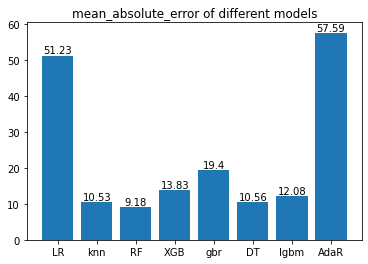

In [51]:
model=("LR","knn","RF","XGB","gbr","DT","lgbm","AdaR")
plt.bar(model, MAE_list)
plt.title("mean_absolute_error of different models") 
for a, b in zip(model, MAE_list):
    plt.text(a, b, round(b,2), ha='center', va='bottom')

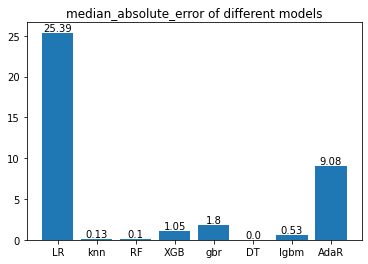

In [52]:
plt.bar(model, medianAe_list)
plt.title("median_absolute_error of different models") 
for a, b in zip(model, medianAe_list):
    plt.text(a, b, round(b,2), ha='center', va='bottom')

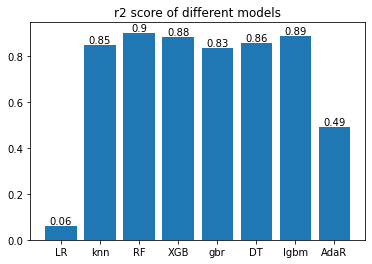

In [53]:
plt.bar(model, r2_score_list)
plt.title("r2 score of different models") 
for a, b in zip(model, r2_score_list):
    plt.text(a, b, round(b,2), ha='center', va='bottom')

In [54]:
######this part is some examples cod for tuning 

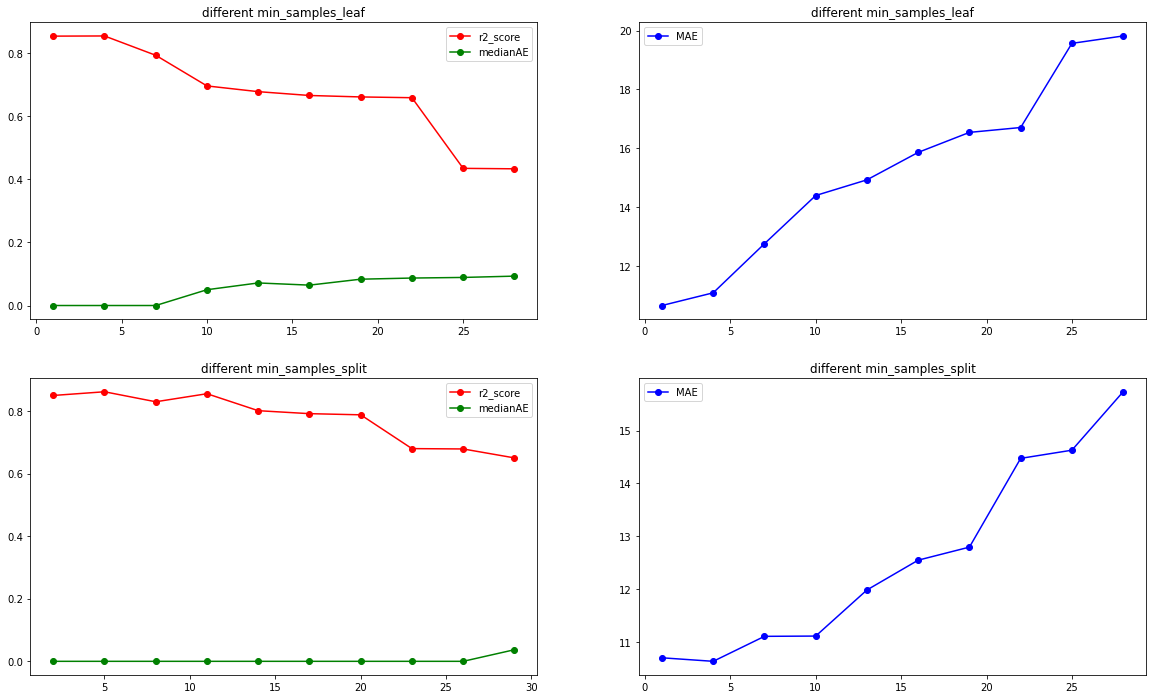

--------------------------------------------------------------


In [55]:
min_samples_leaf_list = range(1,30,3)
DecisionTree_r2_score_list = []
MAE_Decision_list = []
medianAE_dt_confirmcase_list=[]

for item in min_samples_leaf_list:
    DecisionTree = DecisionTreeRegressor(min_samples_leaf = item)
    DecisionTree.fit(train_x_confirmcase, train_y_confirmcase)
    DecisionTree_predict = DecisionTree.predict(test_x_confirmcase)
    DecisionTree_r2_score = r2_score(test_y_confirmcase, DecisionTree_predict)
    MAE_Decision = metrics.mean_absolute_error(test_y_confirmcase, DecisionTree_predict)
    medianAE_dt_confirmcase = metrics.median_absolute_error(test_y_confirmcase, DecisionTree_predict)
    DecisionTree_r2_score_list.append(DecisionTree_r2_score)
    MAE_Decision_list.append(MAE_Decision)
    medianAE_dt_confirmcase_list.append(medianAE_dt_confirmcase)

# color = ['red','brown', 'green']
# label = ['r2_score','MAE','AE']
# DTres = [pd.DataFrame(DecisionTree_r2_score_list),pd.DataFrame(MAE_Decision_list),pd.DataFrame(medianAE_dt_confirmcase_list)] 

# for i in range(0,3):
#     plt.plot(list(min_samples_leaf_list),DTres[i].values ,color[i],label=label[i])

plt.figure(figsize=(20,12)) 

plt.subplot(2,2,1)
plt.plot(list(min_samples_leaf_list),DecisionTree_r2_score_list,'ro-',label='r2_score')
plt.plot(list(min_samples_leaf_list),medianAE_dt_confirmcase_list,'go-',label='medianAE')
plt.title('different min_samples_leaf', fontsize=12)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(list(min_samples_leaf_list), MAE_Decision_list,'bo-',label='MAE')
plt.title('different min_samples_leaf', fontsize=12)
plt.legend()


min_samples_split_list = range(2,30,3)
DecisionTree_r2_score_list = []
MAE_Decision_list = []
medianAE_dt_confirmcase_list=[]

for item in min_samples_split_list:
    DecisionTree = DecisionTreeRegressor(min_samples_split = item)
    DecisionTree.fit(train_x_confirmcase, train_y_confirmcase)
    DecisionTree_predict = DecisionTree.predict(test_x_confirmcase)
    DecisionTree_r2_score = r2_score(test_y_confirmcase, DecisionTree_predict)
    MAE_Decision = metrics.mean_absolute_error(test_y_confirmcase, DecisionTree_predict)
    medianAE_dt_confirmcase = metrics.median_absolute_error(test_y_confirmcase, DecisionTree_predict)
    DecisionTree_r2_score_list.append(DecisionTree_r2_score)
    MAE_Decision_list.append(MAE_Decision)
    medianAE_dt_confirmcase_list.append(medianAE_dt_confirmcase)

plt.subplot(2,2,3)
plt.plot(list(min_samples_split_list),DecisionTree_r2_score_list,'ro-',label='r2_score')
plt.plot(list(min_samples_split_list),medianAE_dt_confirmcase_list,'go-',label='medianAE')
plt.title('different min_samples_split', fontsize=12)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(list(min_samples_leaf_list), MAE_Decision_list,'bo-',label='MAE')
plt.title('different min_samples_split', fontsize=12)
plt.legend()

plt.show()

print("--------------------------------------------------------------")

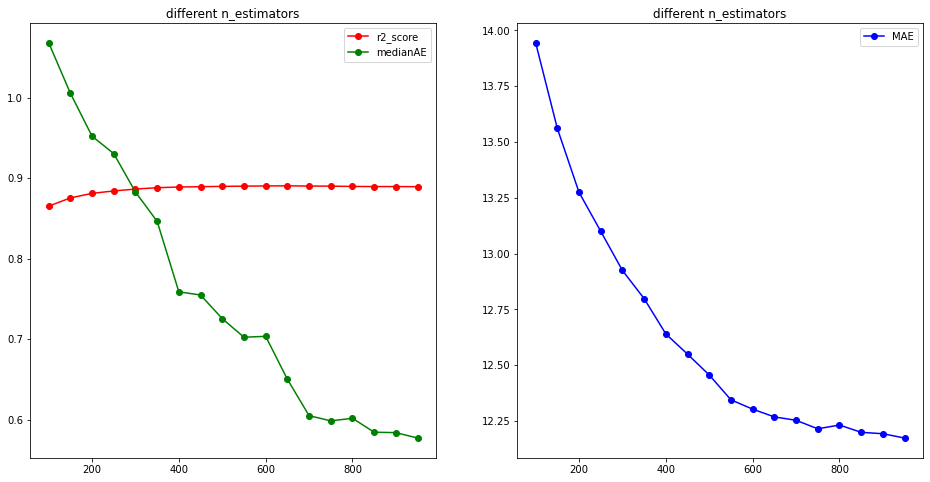

--------------------------------------------------------------


In [56]:
n_estimators_list = range(100,1000,50) 
lgbm_r2_score_list = []
MAE_lgbm_list = []
medianAE_lgbm_confirmcase_list = []

for item in n_estimators_list:
    lgbm = LGBMRegressor(n_estimators=item)
    lgbm.fit(train_x_confirmcase,train_y_confirmcase)
    lgbm_predict = lgbm.predict(test_x_confirmcase)
    lgbm_r2_score = r2_score(test_y_confirmcase, lgbm_predict)
    MAE_lgbm = metrics.mean_absolute_error(test_y_confirmcase, lgbm_predict)
    medianAE_lgbm_confirmcase = metrics.median_absolute_error(test_y_confirmcase, lgbm_predict)
    lgbm_r2_score_list.append(lgbm_r2_score)
    MAE_lgbm_list.append(MAE_lgbm)
    medianAE_lgbm_confirmcase_list.append(medianAE_lgbm_confirmcase)

plt.figure(figsize=(16,8)) 

plt.subplot(1,2,1)
plt.plot(list(n_estimators_list),lgbm_r2_score_list,'ro-',label='r2_score')
plt.plot(list(n_estimators_list),medianAE_lgbm_confirmcase_list,'go-',label='medianAE')
plt.title('different n_estimators', fontsize=12)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list(n_estimators_list), MAE_lgbm_list,'bo-',label='MAE')
plt.title('different n_estimators', fontsize=12)
plt.legend()

plt.show()    
    

print("--------------------------------------------------------------")